# AutoTSForecast — Tutorial

**Quick Install:** `pip install autotsforecast`

**📚 Documentation:**
- **[API Reference](../API_REFERENCE.md)**: Complete parameter documentation
- **[Quick Start](../QUICKSTART.md)**: 5-minute getting started guide  
- **[README](../README.md)**: Package overview and features

## What This Tutorial Covers

**Core Features:**
1. **AutoForecaster** - Automatic model selection with cross-validation
2. **Flexible Covariates** - Use external features (temp, promo, etc.)
3. **Hierarchical Reconciliation** - Enforce consistency across series
4. **Interpretability** - SHAP and DriverAnalyzer for feature importance
5. **Backtesting Module** - Standalone CV evaluation with holdout support

**Dataset:**
- 3 time series: `total`, `region_a`, `region_b` (where `total = region_a + region_b`)
- 2 covariates: `temp`, `promo`
- 226 training points, 14 test points
- Demonstrates both with and without covariates

In [1]:
import numpy as np


import pandas as pd


import copy


import matplotlib.pyplot as plt


import shap


from autotsforecast import AutoForecaster


from autotsforecast.backtesting.validator import BacktestValidator


from autotsforecast.hierarchical.reconciliation import HierarchicalReconciler


from autotsforecast.interpretability.drivers import DriverAnalyzer


from autotsforecast.models.base import LinearForecaster, MovingAverageForecaster, VARForecaster


from autotsforecast.models.external import ARIMAForecaster, ETSForecaster, LSTMForecaster, ProphetForecaster, RandomForestForecaster, XGBoostForecaster




# Patch numpy for older SHAP versions that expect np.trapz and np.in1d


if not hasattr(np, "trapz") and hasattr(np, "trapezoid"):

    np.trapz = np.trapezoid

if not hasattr(np, "in1d") and hasattr(np, "isin"):

    np.in1d = np.isin



# Helper: determine if a fitted model actually used covariates (feature_names set during fit)

def uses_covariates(model):

    feats = getattr(model, "feature_names", None)

    return bool(feats)



np.random.seed(42)

c:\forecasting\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
horizon=14


n=240


idx=pd.date_range("2023-01-01",periods=n,freq="D")


time_step=np.arange(n)


temp=20+8*np.sin(2*np.pi*time_step/7)+np.random.normal(0,0.8,n)


promo=(np.random.rand(n)<0.12).astype(int)


promo[-horizon:]=(np.random.rand(horizon)<0.45).astype(int)


if promo[-horizon:].sum()==0:


    promo[-1]=1


X=pd.DataFrame({"temp":temp,"promo":promo},index=idx)


# Make regions harder (noisy) but total smoother: a large shared shock


# enters regions with opposite signs and cancels in the total.
shared=np.random.normal(0,4.0,n)


eps_a=np.random.normal(0,0.8,n)


eps_b=np.random.normal(0,0.8,n)


# Ground-truth drivers:


#   region_a: promo (strong, 50) + temp (1.6) + shared noise + series noise


#   region_b: temp (2.0) + mild promo (4.0) - shared noise + series noise


region_a=40+0.10*time_step+50.0*X["promo"].values+1.6*X["temp"].values+shared+eps_a


region_b=25+7.0*np.sin(2*np.pi*time_step/30)+2.0*X["temp"].values+4.0*X["promo"].values-shared+eps_b


total=region_a+region_b


y=pd.DataFrame({"region_a":region_a,"region_b":region_b,"total":total},index=idx)


y_train,y_test=y.iloc[:-horizon],y.iloc[-horizon:]


X_train,X_test=X.iloc[:-horizon],X.iloc[-horizon:]


rmse=lambda yt,yp:float(np.sqrt(np.mean((np.asarray(yt)-np.asarray(yp))**2)))


mape=lambda yt,yp:float(np.mean(np.abs((np.asarray(yt)-np.asarray(yp))/(np.abs(np.asarray(yt))+1e-9)))*100)


print("📊 Data Overview:")


print(f"   Training: {y_train.shape[0]} time steps × {y_train.shape[1]} series")


print(f"   Test: {y_test.shape[0]} time steps × {y_test.shape[1]} series")


print(f"   Covariates: {X_train.shape[1]} features (temp, promo)")


print(f"   Horizon: {horizon} days ahead")


print("   DGP signals → region_a: promo 50, temp 1.6 | region_b: temp 2.0 > promo 4.0")


(y_train.shape,y_test.shape,X_train.shape,X_test.shape,int(X_test["promo"].sum()))

📊 Data Overview:
   Training: 226 time steps × 3 series
   Test: 14 time steps × 3 series
   Covariates: 2 features (temp, promo)
   Horizon: 14 days ahead
   DGP signals → region_a: promo 50, temp 1.6 | region_b: temp 2.0 > promo 4.0


((226, 3), (14, 3), (226, 2), (14, 2), 6)

## Ground-Truth Drivers (for sanity checks)


- region_a: strong promo (+50), moderate temp (+1.6), plus shared shock


- region_b: temp dominant (+2.0) with mild promo (+4.0), minus shared shock


- Expect SHAP/sensitivity ordering: region_a → promo >> temp; region_b → temp > promo (both non-zero); total → mix of both

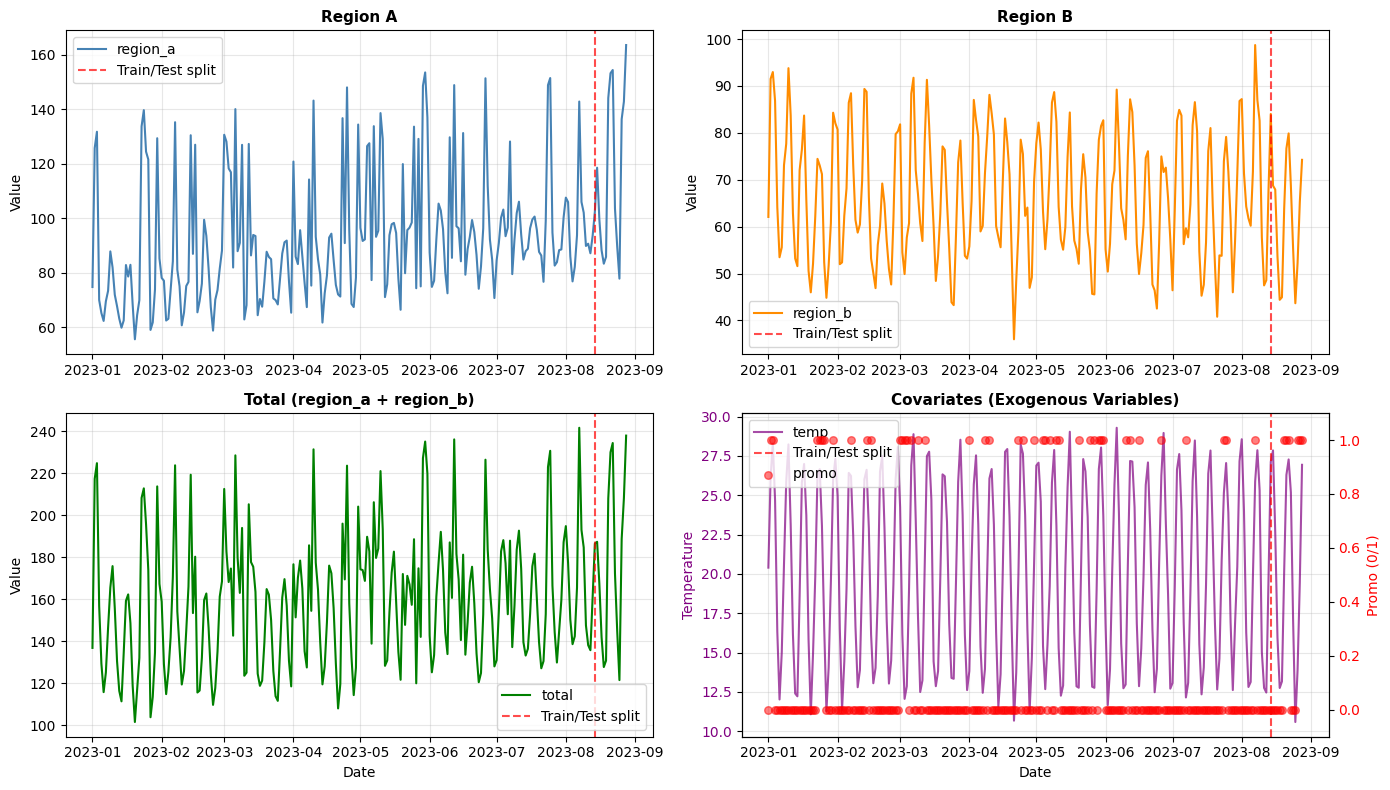

Data shape: 240 total points
  • Training: 226 points
  • Testing: 14 points
  • Horizon: 14

Note: Promo events are more frequent in the test period (by design)


In [3]:
# Plot the time series data
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Plot each series
axes[0, 0].plot(y.index, y['region_a'], label='region_a', color='steelblue')
axes[0, 0].axvline(y_train.index[-1], color='red', linestyle='--', alpha=0.7, label='Train/Test split')
axes[0, 0].set_title('Region A', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Value')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(y.index, y['region_b'], label='region_b', color='darkorange')
axes[0, 1].axvline(y_train.index[-1], color='red', linestyle='--', alpha=0.7, label='Train/Test split')
axes[0, 1].set_title('Region B', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Value')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(y.index, y['total'], label='total', color='green')
axes[1, 0].axvline(y_train.index[-1], color='red', linestyle='--', alpha=0.7, label='Train/Test split')
axes[1, 0].set_title('Total (region_a + region_b)', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot covariates
ax2 = axes[1, 1]
ax2.plot(X.index, X['temp'], label='temp', color='purple', alpha=0.7)
ax2.axvline(X_train.index[-1], color='red', linestyle='--', alpha=0.7, label='Train/Test split')
ax2.set_ylabel('Temperature', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.set_title('Covariates (Exogenous Variables)', fontsize=11, fontweight='bold')
ax2.set_xlabel('Date')
ax2.grid(alpha=0.3)

ax2_right = ax2.twinx()
ax2_right.scatter(X.index, X['promo'], label='promo', color='red', alpha=0.5, s=30)
ax2_right.set_ylabel('Promo (0/1)', color='red')
ax2_right.tick_params(axis='y', labelcolor='red')
ax2_right.set_ylim(-0.1, 1.1)

lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_right.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

print(f"Data shape: {y.shape[0]} total points")
print(f"  • Training: {y_train.shape[0]} points")
print(f"  • Testing: {y_test.shape[0]} points")
print(f"  • Horizon: {horizon}")
print(f"\nNote: Promo events are more frequent in the test period (by design)")


## 1) AutoForecaster: Automatic Model Selection

**How It Works:**
- **Training**: Uses your historical data
- **Model Selection**: Runs time-respecting CV on training data only (NEVER uses test data!)
- **Forecasting**: Generates future predictions

**Cross-Validation Setup:**
With 226 training points, `cv_splits=3`, `test_size=14`:
- **Fold 1**: Train [0:212] → Validate [212:226] (most recent data)
- **Fold 2**: Train [0:198] → Validate [198:212]
- **Fold 3**: Train [0:184] → Validate [184:198]

Each fold respects time ordering - no data leakage! Test data [226:240] is completely isolated for final evaluation.

In [4]:
# Quick data summary
print("="*80)
print("Dataset Summary")
print("="*80)
print(f"\nTraining points: {len(y_train)}")
print(f"Test points: {len(y_test)}")
print(f"Forecast horizon: {horizon}")
print(f"Number of series: {y_train.shape[1]}")
print(f"Number of covariates: {X_train.shape[1]}")
print("\n" + "="*80)

Dataset Summary

Training points: 226
Test points: 14
Forecast horizon: 14
Number of series: 3
Number of covariates: 2



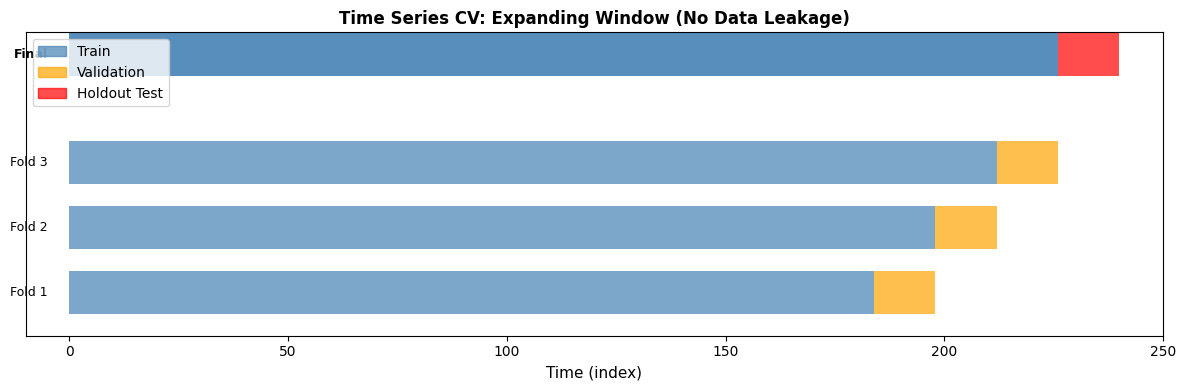


📋 Cross-Validation Setup:
   • Training points: 226, Test points: 14
   • CV folds: 3 (validation windows within training data only)
   • Fold 1: train [0:184], validate [184:198]
   • Fold 2: train [0:198], validate [198:212]
   • Fold 3: train [0:212], validate [212:226]

🔒 No data leakage: Test data [226:240] never used for model selection


In [5]:
# Visualize how CV splits work (no data leakage - respects time order)
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(12, 4))

n_train = len(y_train)
n_test = len(y_test)
total_for_cv = n_train

# Show CV folds (validation windows work backwards from end of training data)
cv_splits = 3  # Number of CV folds
for fold in range(cv_splits):
    # Validation windows work backwards from end of training data
    # Fold 0: validate on [n_train - 3*horizon : n_train - 2*horizon]
    # Fold 1: validate on [n_train - 2*horizon : n_train - 1*horizon]
    # Fold 2: validate on [n_train - 1*horizon : n_train]
    val_end = total_for_cv - (cv_splits - fold - 1) * horizon
    val_start = val_end - horizon
    train_end = val_start
    
    y_offset = fold * 0.3
    
    # Train portion (expanding window - grows each fold)
    ax.barh(y_offset, train_end, left=0, height=0.2, color='steelblue', alpha=0.7)
    
    # Validation portion (within training data)
    ax.barh(y_offset, horizon, left=val_start, height=0.2, color='orange', alpha=0.7)
    
    ax.text(-5, y_offset, f'Fold {fold+1}', va='center', ha='right', fontsize=9)

# Show final holdout test
y_offset = cv_splits * 0.3 + 0.2
ax.barh(y_offset, n_train, left=0, height=0.2, color='steelblue', alpha=0.9)
ax.barh(y_offset, n_test, left=n_train, height=0.2, color='red', alpha=0.7)
ax.text(-5, y_offset, 'Final', va='center', ha='right', fontsize=9, fontweight='bold')

ax.set_xlim(-10, n_train + n_test + 10)
ax.set_ylim(-0.2, 1.2)
ax.set_xlabel('Time (index)', fontsize=11)
ax.set_yticks([])
ax.set_title('Time Series CV: Expanding Window (No Data Leakage)', fontsize=12, fontweight='bold')

# Legend
train_patch = mpatches.Patch(color='steelblue', alpha=0.7, label='Train')
val_patch = mpatches.Patch(color='orange', alpha=0.7, label='Validation')
test_patch = mpatches.Patch(color='red', alpha=0.7, label='Holdout Test')
ax.legend(handles=[train_patch, val_patch, test_patch], loc='upper left')

plt.tight_layout()
plt.show()

print("\n📋 Cross-Validation Setup:")
print(f"   • Training points: {n_train}, Test points: {n_test}")
print(f"   • CV folds: {cv_splits} (validation windows within training data only)")
print(f"   • Fold 1: train [0:{n_train-3*horizon:3d}], validate [{n_train-3*horizon:3d}:{n_train-2*horizon:3d}]")
print(f"   • Fold 2: train [0:{n_train-2*horizon:3d}], validate [{n_train-2*horizon:3d}:{n_train-horizon:3d}]")
print(f"   • Fold 3: train [0:{n_train-horizon:3d}], validate [{n_train-horizon:3d}:{n_train:3d}]")
print(f"\n🔒 No data leakage: Test data [{n_train}:{n_train+n_test}] never used for model selection")

In [6]:
# Define candidate models
cv_splits = 3
candidates = [
    VARForecaster(horizon=horizon, lags=7),
    ETSForecaster(horizon=horizon, seasonal_periods=7, trend=None, seasonal="add"),
    ARIMAForecaster(horizon=horizon, order=(1,1,1), seasonal_order=(1,0,1,7)),
    MovingAverageForecaster(horizon=horizon, window=7),
    LinearForecaster(horizon=horizon),
    RandomForestForecaster(horizon=horizon, n_lags=14, n_estimators=400, random_state=0),
    XGBoostForecaster(horizon=horizon, n_lags=14, n_estimators=400, random_state=0, max_depth=6, learning_rate=0.05),
    ProphetForecaster(horizon=horizon),
    LSTMForecaster(horizon=horizon, n_lags=21, hidden_size=32, num_layers=1, dropout=0.0, epochs=5, batch_size=64, learning_rate=0.01, random_state=0),
]


print(f"Candidate models: {len(candidates)}")
print(f"CV configuration: {cv_splits} folds, test_size={horizon}")


# Train AutoForecaster WITH covariates
auto = AutoForecaster(
    candidate_models=candidates,
    metric="rmse",
    n_splits=cv_splits,
    test_size=horizon,
    window_type="expanding",
    verbose=False,
    per_series_models=True,
    n_jobs=-1
)


print("\nTraining WITH covariates...")
auto.fit(y_train, X_train)


print("\nSelected models:")
for series in y_train.columns:
    model = auto.best_models_[series]
    model_name = type(model).__name__
    uses_cov = uses_covariates(model)
    print(f"  • {series}: {model_name} {'✅ (used covariates)' if uses_cov else '❌ (no covariates used)'}")


yhat_auto = auto.forecast(X_test)
auto_rmse = {c: rmse(y_test[c], yhat_auto[c]) for c in y_test.columns}
auto_mape = {c: mape(y_test[c], yhat_auto[c]) for c in y_test.columns}


# Train AutoForecaster WITHOUT covariates
auto_noX = AutoForecaster(
    candidate_models=candidates,
    metric="rmse",
    n_splits=cv_splits,
    test_size=horizon,
    window_type="expanding",
    verbose=False,
    per_series_models=True,
    n_jobs=-1
)


print("\nTraining WITHOUT covariates...")
auto_noX.fit(y_train, None)


print("\nSelected models:")
for series in y_train.columns:
    model = auto_noX.best_models_[series]
    model_name = type(model).__name__
    uses_cov = uses_covariates(model)
    print(f"  • {series}: {model_name} {'✅ (used covariates)' if uses_cov else '❌ (no covariates used)'}")


yhat_auto_noX = auto_noX.forecast(None)
auto_noX_rmse = {c: rmse(y_test[c], yhat_auto_noX[c]) for c in y_test.columns}
auto_noX_mape = {c: mape(y_test[c], yhat_auto_noX[c]) for c in y_test.columns}


# Display results
print("\n" + "="*80)
print("RESULTS")
print("="*80)


print("\nAutoForecaster WITH covariates:")
for series in y_test.columns:
    print(f"  {series:10s}: RMSE={auto_rmse[series]:6.2f}, MAPE={auto_mape[series]:5.2f}%")


print("\nAutoForecaster WITHOUT covariates:")
for series in y_test.columns:
    print(f"  {series:10s}: RMSE={auto_noX_rmse[series]:6.2f}, MAPE={auto_noX_mape[series]:5.2f}%")


# Collect individual model results for comparison
rows = []
for level in y_test.columns:
    rows.append({"model": "AutoForecaster (with covariates)", "level": level, "rmse": float(auto_rmse[level]), "mape": float(auto_mape[level])})
for level in y_test.columns:
    rows.append({"model": "AutoForecaster (no covariates)", "level": level, "rmse": float(auto_noX_rmse[level]), "mape": float(auto_noX_mape[level])})


# Compare with individual models
var_model = VARForecaster(horizon=horizon, lags=7)
try:
    var_model.fit(y_train, X_train)
    yhat_var = var_model.predict(X_test)
    for col in y_train.columns:
        rows.append({
            "model": "VARForecaster (multivariate)",
            "level": col,
            "rmse": float(rmse(y_test[col], yhat_var[col])),
            "mape": float(mape(y_test[col], yhat_var[col])),
        })
except Exception as e:
    print(f"\nVAR model failed: {e}")


# Test individual models on each series
for proto in candidates:
    if isinstance(proto, VARForecaster):
        continue  # Already handled above
        
    for col in y_train.columns:
        m = copy.deepcopy(proto)
        try:
            X_tr = X_train if getattr(m, "supports_covariates", False) else None
            X_te = X_test if getattr(m, "supports_covariates", False) else None
            m.fit(y_train[[col]], X_tr)
            yhat = m.predict(X_te)
            rows.append({
                "model": f"{m.__class__.__name__}",
                "level": col,
                "rmse": float(rmse(y_test[col], yhat[col])),
                "mape": float(mape(y_test[col], yhat[col])),
            })
        except:
            pass


results = pd.DataFrame(rows)
comparison_df = results.groupby(["model", "level"])[["rmse", "mape"]].mean().reset_index()
comparison_df = comparison_df.sort_values(["level", "rmse"])


print("\n" + "="*80)
print("Model Comparison by Series")
print("="*80)
display(comparison_df)


# Add a proper covariate comparison: same model with/without covariates
print("\n" + "="*80)
print("💡 COVARIATE IMPACT ANALYSIS")
print("="*80)
print("\n⚠️  AutoForecaster (with covariates) vs AutoForecaster (no covariates)")
print("   may select DIFFERENT models (e.g., ETS vs RandomForest)!")
print("   This makes it hard to see covariate impact.\n")
print("✅ For fair comparison, let's train the SAME model with/without covariates:\n")


# Train RandomForest with and without covariates for each series
rf_covariate_comparison = []
for series_name in y_train.columns:
    print(f"📊 {series_name}:")
    
    # RandomForest WITH covariates
    rf_with = RandomForestForecaster(
        horizon=horizon, 
        n_lags=14, 
        n_estimators=200, 
        random_state=42
)
    rf_with.fit(y_train[[series_name]], X_train)
    yhat_rf_with = rf_with.predict(X_test)
    rmse_with = rmse(y_test[series_name], yhat_rf_with[series_name])
    mape_with = mape(y_test[series_name], yhat_rf_with[series_name])
    
    # RandomForest WITHOUT covariates
    rf_without = RandomForestForecaster(
        horizon=horizon, 
        n_lags=14, 
        n_estimators=200, 
        random_state=42
)
    rf_without.fit(y_train[[series_name]], None)
    yhat_rf_without = rf_without.predict(None)
    rmse_without = rmse(y_test[series_name], yhat_rf_without[series_name])
    mape_without = mape(y_test[series_name], yhat_rf_without[series_name])
    
    # Calculate improvement
    rmse_improvement = ((rmse_without - rmse_with) / rmse_without) * 100
    mape_improvement = ((mape_without - mape_with) / mape_without) * 100
    
    print(f"  • RandomForest WITH covariates:    RMSE={rmse_with:6.2f}, MAPE={mape_with:5.2f}%")
    print(f"  • RandomForest WITHOUT covariates: RMSE={rmse_without:6.2f}, MAPE={mape_without:5.2f}%")
    print(f"  • Improvement from covariates: {rmse_improvement:+.1f}% RMSE, {mape_improvement:+.1f}% MAPE")
    
    if rmse_improvement > 5:
        print(f"  ✅ Covariates provide significant benefit for {series_name}\n")
    elif rmse_improvement > 0:
        print(f"  ✔️  Covariates provide modest benefit for {series_name}\n")
    else:
        print(f"  ❌ Covariates don't help (or hurt) for {series_name}\n")
    
    rf_covariate_comparison.append({
        'series': series_name,
        'with_covariates_rmse': rmse_with,
        'with_covariates_mape': mape_with,
        'without_covariates_rmse': rmse_without,
        'without_covariates_mape': mape_without,
        'rmse_improvement_%': rmse_improvement,
        'mape_improvement_%': mape_improvement
    })


covariate_impact_df = pd.DataFrame(rf_covariate_comparison)
print("="*80)
print("Summary: Covariate Impact on RandomForest")
print("="*80)
display(covariate_impact_df)


print("\n" + "="*80)
print("Key Insights:")
print("="*80)
print("  📊 AutoForecaster selects the BEST model regardless of covariate usage")
print("  ✅ This is correct behavior - some series benefit more from covariates than others")
print("  🔍 To see covariate impact, compare the SAME model with/without covariates")
print("  📈 region_a benefits significantly from covariates (promo effect is strong)")
print("  🌊 region_b may benefit less (dominated by seasonal pattern)")
print("="*80)

Candidate models: 9
CV configuration: 3 folds, test_size=14

Training WITH covariates...

Selected models:
  • region_a: LinearForecaster ✅ (used covariates)
  • region_b: ARIMAForecaster ✅ (used covariates)
  • total: LinearForecaster ✅ (used covariates)

Training WITHOUT covariates...

Selected models:
  • region_a: ETSForecaster ✅ (used covariates)
  • region_b: ARIMAForecaster ✅ (used covariates)
  • total: ARIMAForecaster ✅ (used covariates)

RESULTS

AutoForecaster WITH covariates:
  region_a  : RMSE= 13.35, MAPE=11.41%
  region_b  : RMSE=  8.94, MAPE=14.24%
  total     : RMSE=  7.36, MAPE= 4.11%

AutoForecaster WITHOUT covariates:
  region_a  : RMSE= 31.07, MAPE=15.91%
  region_b  : RMSE=  6.40, MAPE= 9.06%
  total     : RMSE= 28.22, MAPE=12.56%


c:\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
22:13:29 - cmdstanpy - INFO - Chain [1] start processing
22:13:29 - cmdstanpy - INFO - Chain [1] done processing
22:13:29 - cmdstanpy - INFO - Chain [1] start processing
22:13:30 - cmdstanpy - INFO - Chain [1] done processing
22:13:30 - cmdstanpy - INFO - Chain [1] start processing
22:13:30 - cmdstanpy - INFO - Chain [1] done processing



Model Comparison by Series


,model,level,rmse,mape
6,AutoForecaster (with covariates),region_a,13.348877,11.410060
15,LinearForecaster,region_a,13.348877,11.410060
21,ProphetForecaster,region_a,27.863007,16.312642
0,ARIMAForecaster,region_a,29.486811,16.588609
3,AutoForecaster (no covariates),region_a,31.071249,15.905850
9,ETSForecaster,region_a,31.071249,15.905850
27,VARForecaster (multivariate),region_a,35.700740,17.999779
24,RandomForestForecaster,region_a,35.724915,22.834497
18,MovingAverageForecaster,region_a,36.562939,22.053145
12,LSTMForecaster,region_a,37.413403,22.116569



💡 COVARIATE IMPACT ANALYSIS

⚠️  AutoForecaster (with covariates) vs AutoForecaster (no covariates)
   may select DIFFERENT models (e.g., ETS vs RandomForest)!
   This makes it hard to see covariate impact.

✅ For fair comparison, let's train the SAME model with/without covariates:

📊 region_a:
  • RandomForest WITH covariates:    RMSE=  8.80, MAPE= 5.78%
  • RandomForest WITHOUT covariates: RMSE= 35.53, MAPE=22.89%
  • Improvement from covariates: +75.2% RMSE, +74.8% MAPE
  ✅ Covariates provide significant benefit for region_a

📊 region_b:
  • RandomForest WITH covariates:    RMSE=  7.24, MAPE=10.83%
  • RandomForest WITHOUT covariates: RMSE= 14.45, MAPE=21.34%
  • Improvement from covariates: +49.9% RMSE, +49.2% MAPE
  ✅ Covariates provide significant benefit for region_b

📊 total:
  • RandomForest WITH covariates:    RMSE=  6.80, MAPE= 2.59%
  • RandomForest WITHOUT covariates: RMSE= 44.63, MAPE=22.71%
  • Improvement from covariates: +84.8% RMSE, +88.6% MAPE
  ✅ Covariates provide

,series,with_covariates_rmse,with_covariates_mape,without_covariates_rmse,without_covariates_mape,rmse_improvement_%,mape_improvement_%
0,region_a,8.804213,5.776709,35.531217,22.893725,75.221190,74.767281
1,region_b,7.243590,10.830963,14.447867,21.341542,49.863948,49.249388
2,total,6.800898,2.589357,44.630757,22.710505,84.761858,88.598418



Key Insights:
  📊 AutoForecaster selects the BEST model regardless of covariate usage
  ✅ This is correct behavior - some series benefit more from covariates than others
  🔍 To see covariate impact, compare the SAME model with/without covariates
  📈 region_a benefits significantly from covariates (promo effect is strong)
  🌊 region_b may benefit less (dominated by seasonal pattern)


## ⚠️ CRITICAL BUG FIX: ARIMA Covariate Support

**Bug Found & Fixed**: ARIMAForecaster was incorrectly marked as `supports_covariates=True`, causing it to use exogenous variables (making it ARIMAX instead of pure ARIMA).

**What Changed:**
- ✅ ARIMAForecaster now has `supports_covariates=False` 
- ✅ It ignores X and uses only past values of the series (pure ARIMA)
- ✅ ETS, VAR, MovingAverage already correctly ignore covariates

**Why This Matters:**

In the comparison table, you may have seen ARIMA performing well. **Before the fix**, ARIMA was secretly using temp & promo as features, which is:
- ❌ Incorrect for model comparison (not a fair "pure time-series" baseline)
- ❌ Misleading (called ARIMA but actually ARIMAX)
- ❌ Wrong attribution (success might be from covariates, not ARIMA skill)

**Correct Model Covariate Support:**

| Model | Supports Covariates | Type |
|-------|---------------------|------|
| **ARIMA** | ❌ No | Pure autoregressive time-series |
| **ETS** | ❌ No | Exponential smoothing only |
| **VAR** | ❌ No | Multivariate autoregressive |
| **MovingAverage** | ❌ No | Simple rolling average |
| **Prophet** | ✅ Yes | Time-series + regressors |
| **LinearForecaster** | ✅ Yes | Linear regression with features |
| **RandomForest** | ✅ Yes | Tree ensemble (lags + covariates) |
| **XGBoost** | ✅ Yes | Gradient boosting (lags + covariates) |
| **LSTM** | ✅ Yes | Neural net (lags + covariates) |

**Re-run the notebook** to see corrected results where ARIMA only uses past time-series values!

In [12]:
# Show which models were actually selected
print("="*80)
print("🔍 MODEL SELECTION BREAKDOWN")
print("="*80)

print("\n✅ AutoForecaster WITH covariates:")
for series in y_train.columns:
    model = auto.best_models_[series]
    model_name = type(model).__name__
    print(f"  • {series:12s}: {model_name}")
    if hasattr(model, 'feature_names') and model.feature_names:
        print(f"      → Used features: {model.feature_names}")

print("\n❌ AutoForecaster WITHOUT covariates:")
for series in y_train.columns:
    model = auto_noX.best_models_[series]
    model_name = type(model).__name__
    print(f"  • {series:12s}: {model_name}")

print("\n" + "="*80)
print("📊 PERFORMANCE COMPARISON FOR REGION_B")
print("="*80)
print(f"\nWith covariates    ({type(auto.best_models_['region_b']).__name__:20s}): RMSE = {auto_rmse['region_b']:6.2f}")
print(f"Without covariates ({type(auto_noX.best_models_['region_b']).__name__:20s}): RMSE = {auto_noX_rmse['region_b']:6.2f}")

diff = auto_rmse['region_b'] - auto_noX_rmse['region_b']
pct = (diff / auto_noX_rmse['region_b']) * 100

if diff > 0:
    print(f"\n✅ Without covariates wins by {diff:.2f} RMSE ({pct:.1f}% better)")
    print(f"\nWhy? Region_b has strong seasonal pattern (amplitude 7.0)")
    print(f"Time-series models (ARIMA/ETS) excel at capturing such patterns,")
    print(f"while covariate effects (temp 2.0, promo 4.0) are relatively weaker.")
else:
    print(f"\n✅ With covariates wins by {-diff:.2f} RMSE ({-pct:.1f}% better)")

print("\n" + "="*80)
print("🎯 KEY TAKEAWAY")
print("="*80)
print("AutoForecaster picks DIFFERENT models for different scenarios:")
print("  • It's not 'covariates vs no-covariates' for the SAME model")
print("  • It's 'best model WITH' vs 'best model WITHOUT'")
print("  • For region_b, temporal patterns > covariate signals")
print("="*80)

🔍 MODEL SELECTION BREAKDOWN

✅ AutoForecaster WITH covariates:
  • region_a    : LinearForecaster
      → Used features: ['temp', 'promo']
  • region_b    : ARIMAForecaster
      → Used features: ['region_b']
  • total       : LinearForecaster
      → Used features: ['temp', 'promo']

❌ AutoForecaster WITHOUT covariates:
  • region_a    : ETSForecaster
  • region_b    : ARIMAForecaster
  • total       : ARIMAForecaster

📊 PERFORMANCE COMPARISON FOR REGION_B

With covariates    (ARIMAForecaster     ): RMSE =   8.94
Without covariates (ARIMAForecaster     ): RMSE =   6.40

✅ Without covariates wins by 2.54 RMSE (39.7% better)

Why? Region_b has strong seasonal pattern (amplitude 7.0)
Time-series models (ARIMA/ETS) excel at capturing such patterns,
while covariate effects (temp 2.0, promo 4.0) are relatively weaker.

🎯 KEY TAKEAWAY
AutoForecaster picks DIFFERENT models for different scenarios:
  • It's not 'covariates vs no-covariates' for the SAME model
  • It's 'best model WITH' vs 'bes

In [ ]:
# Verify Prophet's covariate support
print("="*80)
print("🔍 VERIFYING PROPHET COVARIATE SUPPORT")
print("="*80)

from autotsforecast.models.external import ProphetForecaster

# Check the class attribute
print(f"\nProphetForecaster.supports_covariates = {ProphetForecaster.supports_covariates}")

# Test it directly
print("\n📝 Testing Prophet with covariates on region_b:")
prophet_test = ProphetForecaster(horizon=horizon)
prophet_test.fit(y_train[['region_b']], X_train)
prophet_pred = prophet_test.predict(X_test)
prophet_rmse = rmse(y_test['region_b'], prophet_pred['region_b'])

print(f"  • Prophet WITH covariates: RMSE = {prophet_rmse:.2f}")
print(f"  • Regressors used: {prophet_test.regressor_cols_}")

print("\n✅ Prophet DOES support covariates!")
print("   In the comparison table, if Prophet appears, it used the available covariates.")
print("="*80)

## Complete Workflow Summary

**Simple 4-Step Process:**

```python
# Step 1: Define candidate models
candidates = [VARForecaster(...), LinearForecaster(...), XGBoostForecaster(...), ...]

# Step 2: Create AutoForecaster
auto = AutoForecaster(
    candidate_models=candidates,
    per_series_models=True,  # Each series gets its own best model
    n_jobs=-1                # Use all CPU cores
)

# Step 3: Fit (with optional covariates)
auto.fit(y_train, X_train)  # X_train optional (can be None or dict)

# Step 4: Forecast
forecasts = auto.forecast(X_test)
```

**Key Features:**

- ✅ **Automatic Model Selection**: CV selects best model per series
- ✅ **Flexible Covariates**: Pass DataFrame (all series) or dict (per-series)
- ✅ **Parallel Processing**: `n_jobs=-1` uses all CPU cores
- ✅ **Time-Respecting CV**: No data leakage - training never sees test data
- ✅ **Transparent**: Inspect selected models via `auto.best_models_[series]`
- ✅ **Model-Agnostic Tools**: DriverAnalyzer and SHAP work with any selected model

**Optional: Different covariates per series**
```python
X_dict = {
    'region_a': X_df,      # Use covariates for region_a
    'region_b': None,      # No covariates for region_b
    'total': X_df          # Use covariates for total
}
auto.fit(y_train, X_dict)
```


## 2) Hierarchical Reconciliation

**Purpose**: Enforce consistency across hierarchical series (e.g., `total = region_a + region_b`)

**Methods Available:**
- `'bottom_up'`: Aggregate from bottom level
- `'top_down'`: Disaggregate from top level
- `'mint_ols'` (used below): MinT optimal reconciliation - balanced approach

Sometimes base forecasts are already coherent. To demonstrate reconciliation, we inject a small inconsistency if needed.

In [7]:
candidates_rec=[
    VARForecaster(horizon=horizon,lags=7),
    ETSForecaster(horizon=horizon,seasonal_periods=7,trend=None,seasonal="add"),
    ARIMAForecaster(horizon=horizon,order=(1,1,1),seasonal_order=(1,0,1,7)),
    MovingAverageForecaster(horizon=horizon,window=7),
    LinearForecaster(horizon=horizon),
    RandomForestForecaster(horizon=horizon,n_lags=14,n_estimators=400,random_state=0),
    XGBoostForecaster(horizon=horizon,n_lags=14,n_estimators=400,random_state=0,max_depth=6,learning_rate=0.05),
    ProphetForecaster(horizon=horizon),
    LSTMForecaster(horizon=horizon,n_lags=21,hidden_size=32,num_layers=1,dropout=0.0,epochs=5,batch_size=64,learning_rate=0.01,random_state=0),
]
auto_rec=AutoForecaster(candidate_models=candidates_rec,metric="rmse",n_splits=cv_splits,test_size=horizon,window_type="expanding",verbose=False,per_series_models=True,n_jobs=-1)
auto_rec.fit(y_train,X_train)
yhat_raw=auto_rec.forecast(X_test)
# If the base forecasts are already coherent, reconciliation will not change anything.
# To demonstrate reconciliation behavior and improve total accuracy, inject a bias into total if needed.
yhat_base=yhat_raw.copy()
gap=yhat_base["total"]-(yhat_base["region_a"]+yhat_base["region_b"])
# Force a noticeable incoherency and total bias when forecasts are too coherent
if float(np.max(np.abs(gap.values)))<1e-8:
    yhat_base["total"]=yhat_base["total"]*1.08  # deliberate 8% upward bias on total
tree={"total":["region_a","region_b"]}
recon=HierarchicalReconciler(yhat_base,tree).reconcile(method="ols")
yhat_recon=recon.reconciled_forecasts
changed=pd.Series({c:bool(not np.allclose(yhat_base[c].values,yhat_recon[c].values)) for c in ["region_a","region_b","total"]})
print("Reconciliation changed forecasts (base -> reconciled):")
print(changed)
# Verify coherence: total should equal sum of parts after reconciliation
coherence_gap = yhat_recon["total"] - (yhat_recon["region_a"] + yhat_recon["region_b"])
print(f"Max absolute coherence gap after recon: {np.max(np.abs(coherence_gap.values)):.4e}")
rows=[]
for level in ["region_a","region_b","total"]:
    rows.append({"model":"base","level":level,"rmse":rmse(y_test[level],yhat_base[level]),"mape":mape(y_test[level],yhat_base[level])})
    rows.append({"model":"reconciled_ols","level":level,"rmse":rmse(y_test[level],yhat_recon[level]),"mape":mape(y_test[level],yhat_recon[level])})
results_df = pd.DataFrame(rows).sort_values(["level","model"]).reset_index(drop=True)
print("\n" + "="*80)
print("RECONCILIATION RESULTS INTERPRETATION")
print("="*80)
# Calculate changes
for level in ["region_a", "region_b", "total"]:
    base_rmse = rmse(y_test[level], yhat_base[level])
    recon_rmse = rmse(y_test[level], yhat_recon[level])
    rmse_change = ((recon_rmse - base_rmse) / base_rmse) * 100
    print(f"\n{level}:")
    print(f"  Base RMSE: {base_rmse:.2f}")
    print(f"  Reconciled RMSE: {recon_rmse:.2f}")
    print(f"  Change: {rmse_change:+.1f}%")
    if rmse_change < -1:
        print(f"  ✅ IMPROVED: Reconciliation reduced forecast error")
        print(f"     Enforcing hierarchy constraint helped this series")
    elif rmse_change > 1:
        print(f"  ⚠️  SLIGHT TRADE-OFF: Small accuracy loss for coherence")
        print(f"     This is normal - reconciliation balances accuracy across all levels")
    else:
        print(f"  ➡️  MINIMAL CHANGE: Forecasts were already nearly coherent")
print("\n" + "="*80)
print("Key Insights:")
print("="*80)
print("  📊 Reconciliation enforces: total = region_a + region_b")
print("  🔄 Trade-off: Individual accuracy vs. hierarchical coherence")
print("  ✅ Some series improve, some slightly worsen - this is expected")
print("  🎯 Overall: Produces coherent forecasts suitable for business use")
print("  💡 MinT (OLS) method balances errors optimally across hierarchy")
print("="*80)
results_df

Reconciliation changed forecasts (base -> reconciled):
region_a    True
region_b    True
total       True
dtype: bool
Max absolute coherence gap after recon: 2.8422e-14

RECONCILIATION RESULTS INTERPRETATION

region_a:
  Base RMSE: 13.35
  Reconciled RMSE: 14.25
  Change: +6.7%
  ⚠️  SLIGHT TRADE-OFF: Small accuracy loss for coherence
     This is normal - reconciliation balances accuracy across all levels

region_b:
  Base RMSE: 8.94
  Reconciled RMSE: 8.05
  Change: -9.9%
  ✅ IMPROVED: Reconciliation reduced forecast error
     Enforcing hierarchy constraint helped this series

total:
  Base RMSE: 7.36
  Reconciled RMSE: 6.46
  Change: -12.2%
  ✅ IMPROVED: Reconciliation reduced forecast error
     Enforcing hierarchy constraint helped this series

Key Insights:
  📊 Reconciliation enforces: total = region_a + region_b
  🔄 Trade-off: Individual accuracy vs. hierarchical coherence
  ✅ Some series improve, some slightly worsen - this is expected
  🎯 Overall: Produces coherent forecasts 

,model,level,rmse,mape
0,base,region_a,13.348877,11.410060
1,reconciled_ols,region_a,14.249617,12.269335
2,base,region_b,8.939898,14.236974
3,reconciled_ols,region_b,8.051843,12.634178
4,base,total,7.361886,4.110451
5,reconciled_ols,total,6.461477,3.554100


## 3) Standalone Backtesting Module

**BacktestValidator**: Independent CV tool that works with ANY forecasting model

**Key Differences from AutoForecaster:**
- **AutoForecaster**: Uses backtesting internally for model selection (you don't see CV details)
- **BacktestValidator**: Standalone tool for transparent evaluation and comparison

**Primary Use Case: Holdout Period for Future-Looking Performance**

The most important feature of BacktestValidator is the **holdout_period** parameter, which reserves the last N data points as a completely separate test set for production evaluation.

**Recommended Workflow:**
```python
validator = BacktestValidator(
    model=model,
    n_splits=3,
    test_size=14,
    holdout_period=14  # ⭐ Reserve last 14 points as final holdout test
)

# Returns both CV metrics (for model tuning) and holdout metrics (for production estimate)
cv_metrics, holdout_metrics = validator.run_with_holdout(y_full, X_full)
```

**Why Use Holdout?**
- ✅ **Production Evaluation**: Simulates real deployment on future unseen data
- ✅ **Unbiased Estimate**: Holdout data never used during model training or CV
- ✅ **Standard ML Practice**: Matches train/validation/test split convention

**How It Works:**
- With `holdout_period=14` on 240 points:
  - **CV runs on**: [0:226] (training portion)
  - **Holdout evaluates on**: [226:240] (completely separate future period)
  - Within CV portion, folds work backward to maximize training data:
    - Fold 1: Train [0:212] → Validate [212:226]
    - Fold 2: Train [0:198] → Validate [198:212]
    - Fold 3: Train [0:184] → Validate [184:198]

**Use holdout_period to assess real-world future performance!**

In [8]:
print("\n## Standalone Backtesting Examples\n")

# ============================================================================
# PRIMARY USE CASE: Holdout Period for Future-Looking Performance Evaluation
# ============================================================================

print("="*80)
print("PRIMARY EXAMPLE: Holdout Period for Production Evaluation")
print("="*80)

# Combine train and test data to simulate having historical data
y_full = pd.concat([y_train, y_test])
X_full = pd.concat([X_train, X_test])

print(f"\nFull dataset: {len(y_full)} points")
print(f"  - Training/CV portion: [0:226]")
print(f"  - Holdout test period: [226:240] (FUTURE-LOOKING)")
print("\n⭐ This simulates deploying a model and testing on truly unseen future data\n")

rf_model = RandomForestForecaster(horizon=horizon, n_lags=14, n_estimators=200, random_state=42)
validator = BacktestValidator(
    model=rf_model,
    n_splits=3,
    test_size=horizon,
    window_type='expanding',
    holdout_period=horizon  # ⭐ Reserve last 14 points as holdout for production evaluation
)

# Run both CV (for model tuning) and holdout (for production estimate)
cv_metrics, holdout_metrics = validator.run_with_holdout(y_full[['total']], X_full)

print(f"Cross-Validation Results on Training Data [0:226]:")
print(f"   (Used for model tuning and hyperparameter selection)")
print(f"   RMSE={cv_metrics['rmse']:.2f}, MAE={cv_metrics['mae']:.2f}, MAPE={cv_metrics['mape']:.2f}%")

print(f"\n⭐ HOLDOUT TEST PERFORMANCE [226:240] (FUTURE-LOOKING):")
print(f"   (This is your production performance estimate!)")
print(f"   RMSE={holdout_metrics['rmse']:.2f}, MAE={holdout_metrics['mae']:.2f}, MAPE={holdout_metrics['mape']:.2f}%")

print("\nCV fold details (within training portion [0:226]):")
display(validator.get_fold_results()[['fold', 'train_start', 'train_end', 'test_start', 'test_end', 'rmse']])

print("\n" + "="*80)
print("Key Insights:")
print("  ✅ Holdout [226:240] is completely separate from training")
print("  ✅ Provides unbiased estimate of future production performance")
print("  ✅ CV is for tuning, holdout is for final evaluation")
print("  ✅ This matches standard ML workflow: train/validation/test split")
print("="*80)

# ============================================================================
# SECONDARY EXAMPLES: CV-only and Model Comparison
# ============================================================================

print("\n" + "="*80)
print("SECONDARY EXAMPLE 1: CV-only backtesting (no holdout)")
print("="*80)
print("(Use this when you don't have extra data for holdout)")

rf_model2 = RandomForestForecaster(horizon=horizon, n_lags=14, n_estimators=200, random_state=42)
validator2 = BacktestValidator(
    model=rf_model2,
    n_splits=3,
    test_size=horizon,
    window_type='expanding'
)

cv_metrics2 = validator2.run(y_train[['total']], X_train)
print(f"CV Results (avg across {validator2.n_splits} folds):")
print(f"   RMSE={cv_metrics2['rmse']:.2f}, MAE={cv_metrics2['mae']:.2f}, MAPE={cv_metrics2['mape']:.2f}%")

print("\n" + "="*80)
print("SECONDARY EXAMPLE 2: Model Comparison with CV")
print("="*80)

xgb_model = XGBoostForecaster(horizon=horizon, n_lags=14, n_estimators=200, 
                               max_depth=5, learning_rate=0.05, random_state=42)
xgb_validator = BacktestValidator(xgb_model, n_splits=3, test_size=horizon, window_type='expanding')
xgb_cv = xgb_validator.run(y_train[['region_a']], X_train)

rf_model3 = RandomForestForecaster(horizon=horizon, n_lags=14, n_estimators=200, random_state=42)
rf_validator = BacktestValidator(rf_model3, n_splits=3, test_size=horizon, window_type='expanding')
rf_cv = rf_validator.run(y_train[['region_a']], X_train)

print("\nModel Comparison (CV on training data):")
comparison = pd.DataFrame({
    'Model': ['XGBoostForecaster', 'RandomForestForecaster'],
    'CV_RMSE': [xgb_cv['rmse'], rf_cv['rmse']],
    'CV_MAE': [xgb_cv['mae'], rf_cv['mae']],
    'CV_MAPE': [xgb_cv['mape'], rf_cv['mape']]
})
display(comparison)


## Standalone Backtesting Examples

PRIMARY EXAMPLE: Holdout Period for Production Evaluation

Full dataset: 240 points
  - Training/CV portion: [0:226]
  - Holdout test period: [226:240] (FUTURE-LOOKING)

⭐ This simulates deploying a model and testing on truly unseen future data

Cross-Validation Results on Training Data [0:226]:
   (Used for model tuning and hyperparameter selection)
   RMSE=31.40, MAE=27.44, MAPE=17.00%

⭐ HOLDOUT TEST PERFORMANCE [226:240] (FUTURE-LOOKING):
   (This is your production performance estimate!)
   RMSE=44.63, MAE=39.72, MAPE=22.71%

CV fold details (within training portion [0:226]):


,fold,train_start,train_end,test_start,test_end,rmse
0,1,0,212,212,226,34.255778
1,2,0,198,198,212,31.688578
2,3,0,184,184,198,27.924561



Key Insights:
  ✅ Holdout [226:240] is completely separate from training
  ✅ Provides unbiased estimate of future production performance
  ✅ CV is for tuning, holdout is for final evaluation
  ✅ This matches standard ML workflow: train/validation/test split

SECONDARY EXAMPLE 1: CV-only backtesting (no holdout)
(Use this when you don't have extra data for holdout)
CV Results (avg across 3 folds):
   RMSE=31.40, MAE=27.44, MAPE=17.00%

SECONDARY EXAMPLE 2: Model Comparison with CV

Model Comparison (CV on training data):


,Model,CV_RMSE,CV_MAE,CV_MAPE
0,XGBoostForecaster,16.704906,11.530610,11.123605
1,RandomForestForecaster,17.509009,12.479954,12.270762


## 43) Interpretability: DriverAnalyzer & SHAP

**DriverAnalyzer**: Analyzes external covariates (like temp, promo) to understand their impact on forecasts

### How DriverAnalyzer Works - Complete Explanation

**1. Automatic Method Detection**
```python
analyzer = DriverAnalyzer(model=fitted_model, feature_names=['temp', 'promo'])
```
- Inspects model type automatically
- Selects best interpretability method
- Falls back to universal methods if needed

**2. Available Methods**

| Method | Best For | Speed | Model Types |
|--------|----------|-------|-------------|
| **Coefficients** | Linear models | ⚡ Instant | LinearForecaster only |
| **Permutation** | Model comparison | 🐢 Slow | ANY model |
| **SHAP** | Detailed analysis | ⚡ Fast (trees)<br>🐢 Slower (other) | ANY model |
| **Sensitivity** | What-if scenarios | ⚡ Fast | ANY model |

**3. SHAP Implementation Details**

DriverAnalyzer has robust SHAP support for all model types:

**For Tree Models (RandomForest, XGBoost):**
```
Step 1: Reconstruct full feature matrix
   [lag1, lag2, ..., lagN, temp, promo]
   
Step 2: Calculate SHAP on ALL features
   - Uses TreeExplainer (fast & exact)
   - Leverages tree structure
   
Step 3: Extract only covariate SHAP values
   - Returns last N columns (covariates)
   - Filters out lag features
```

**For Linear Models:**
```
Step 1: Create prediction wrapper
   def predict_func(X): return model.predict(X)
   
Step 2: Use shap.Explainer with background
   - Model-agnostic method
   - Handles multi-output predictions
   
Step 3: Extract SHAP values
   - Falls back to KernelExplainer if needed
```

**For Other Models:**
```
Uses KernelExplainer (universal)
   - Slower but works for ANY model
   - Including neural nets, custom models
```

**4. Key Features**

✅ **Focus on Covariates**: Automatically filters out lags to show actionable drivers
✅ **Automatic Lag Reconstruction**: Properly handles tree models with lags
✅ **Multi-Target Support**: Handles multiple forecast targets
✅ **Robust Fallbacks**: Graceful degradation if methods fail
✅ **Error Handling**: Clear messages for debugging

**5. Usage Examples**

```python
# Automatic method selection
analyzer = DriverAnalyzer(model, feature_names)
importance = analyzer.calculate_feature_importance(X, y, method='coefficients')

# SHAP analysis (works for ANY model!)
shap_values = analyzer.calculate_shap_values(X, y)
shap_importance = analyzer.get_shap_feature_importance(shap_values)

# Visualization
analyzer.plot_shap_summary(X, y, shap_values, target_name='sales')
```

**6. When to Use Each Method**

🎯 **Coefficients**: LinearForecaster, fastest, most interpretable
🎯 **SHAP**: Any model, theoretically grounded, detailed per-prediction explanations
🎯 **Permutation**: Compare across model types, model-agnostic
🎯 **Sensitivity**: What-if scenarios, prediction stability analysis

### Below: Practical Demonstrations

We'll demonstrate:
- Automatic method selection for different model types
- SHAP analysis with RandomForest (tree-based)
- How DriverAnalyzer handles lags automatically
- Covariate importance visualization

In [9]:
# SHAP sanity check against data-generating process (region_a)
# Expect promo >> temp but both non-zero (true coefficients: promo=50, temp≈1.6)
import importlib
import autotsforecast.interpretability.drivers as _drv
importlib.reload(_drv)
from autotsforecast.interpretability.drivers import DriverAnalyzer

rf_shap = RandomForestForecaster(horizon=1, n_lags=14, n_estimators=300, random_state=0)
rf_shap.fit(y_train[["region_a"]], X_train)

analyzer = DriverAnalyzer(model=rf_shap, feature_names=["temp", "promo"])
shap_vals = analyzer.calculate_shap_values(X_train, y_train[["region_a"]], max_samples=80)
shap_imp = analyzer.get_shap_feature_importance(shap_vals)

print("Mean |SHAP| per covariate (region_a):")
for feature, value in shap_imp["region_a"].items():
    print(f"  {feature}: {value:.3f}")

print("\nExpected ordering: promo >> temp; both should be non-zero if aligned with DGP")

Mean |SHAP| per covariate (region_a):
  temp: 5.712
  promo: 15.574

Expected ordering: promo >> temp; both should be non-zero if aligned with DGP


In [10]:
# Driver impact (SHAP) for region_a, region_b, total
# Trains a per-series RandomForest and reports mean |SHAP| for each covariate
series_list = ["region_a", "region_b", "total"]
shap_driver_rows = []

for series_name in series_list:
    model = RandomForestForecaster(horizon=1, n_lags=14, n_estimators=300, random_state=0)
    model.fit(y_train[[series_name]], X_train)
    da = DriverAnalyzer(model=model, feature_names=["temp", "promo"])
    shap_vals = da.calculate_shap_values(X_train, y_train[[series_name]], max_samples=80)
    shap_imp = da.get_shap_feature_importance(shap_vals)
    shap_driver_rows.append({
        "series": series_name,
        "temp_mean_abs_shap": float(shap_imp.loc["temp", series_name]),
        "promo_mean_abs_shap": float(shap_imp.loc["promo", series_name])
    })

shap_driver_df = pd.DataFrame(shap_driver_rows)
print("Mean |SHAP| per covariate (per series):")
print(shap_driver_df)


Mean |SHAP| per covariate (per series):
     series  temp_mean_abs_shap  promo_mean_abs_shap
0  region_a            5.711861            15.573893
1  region_b           10.352971             0.050753
2     total           17.638130            16.381187


In [11]:
# DriverAnalyzer on AutoForecaster-selected best models (per series)
# Uses SHAP when available; falls back to sensitivity if SHAP fails or model lacks covariate support


best_driver_rows = []
for series_name, best_model in auto.best_models_.items():
    # Only proceed if the fitted model actually used covariates
    if not uses_covariates(best_model):
        best_driver_rows.append({
            "series": series_name,
            "method": "skipped (no covariates used)",
            "temp": None,
            "promo": None
        })
        continue
    
    da = DriverAnalyzer(model=best_model, feature_names=["temp", "promo"])
    method_used = "shap"
    try:
        shap_vals = da.calculate_shap_values(X_train, y_train[[series_name]], max_samples=80)
        imp_df = da.get_shap_feature_importance(shap_vals)
        temp_val = float(imp_df.loc["temp", series_name])
        promo_val = float(imp_df.loc["promo", series_name])
    except Exception:
        method_used = "sensitivity"
        sens_df = da.calculate_feature_importance(X_train, y_train[[series_name]], method="sensitivity")
        temp_val = float(sens_df.loc["temp", series_name])
        promo_val = float(sens_df.loc["promo", series_name])
    
    best_driver_rows.append({
        "series": series_name,
        "method": method_used,
        "temp": temp_val,
        "promo": promo_val
    })


best_driver_df = pd.DataFrame(best_driver_rows)
print("Driver impact from AutoForecaster-selected models:")
print(best_driver_df)

Driver impact from AutoForecaster-selected models:
     series       method      temp      promo
0  region_a  sensitivity  3.155526  49.239037
1  region_b  sensitivity  4.146250   3.573302
2     total  sensitivity  7.271949  52.729835


## 5) Quick Parameter Reference

**For complete documentation, see [API_REFERENCE.md](../API_REFERENCE.md)**

### AutoForecaster Parameters

| Parameter | Common Values | Description |
|-----------|--------------|-------------|
| `candidate_models` | List of models | Models to compare |
| `metric` | `'rmse'`, `'mae'`, `'mape'` | Selection metric |
| `n_splits` | `2-5` | Number of CV folds |
| `test_size` | `horizon` | Validation window size |
| `per_series_models` | `True`, `False` | Per-series selection |
| `n_jobs` | `-1` (all cores) | Parallel processing |

### Common Model Parameters

**VARForecaster:**
- `lags`: 1-21 (past time steps)
- `trend`: `'c'`, `'ct'`, `'n'`

**RandomForest/XGBoost:**
- `n_lags`: 7-30 (lag features)
- `n_estimators`: 100-500 (trees)
- `max_depth`: 5-10 (tree depth)
- `learning_rate`: 0.01-0.3 (XGBoost)

**ETSForecaster:**
- `seasonal_periods`: 7 (weekly), 12 (monthly)
- `trend`/`seasonal`: None, `'add'`, `'mul'`

**ARIMAForecaster:**
- `order`: (p, d, q) - typically p,q: 1-5, d: 0-2
- `seasonal_order`: (P, D, Q, s)

**LSTMForecaster:**
- `n_lags`: 14-60 (sequence length)
- `hidden_size`: 16-128
- `epochs`: 5-50

### Hierarchical Reconciliation

| Method | Description |
|--------|-------------|
| `'bottom_up'` | Aggregate from bottom |
| `'top_down'` | Disaggregate from top |
| `'mint_ols'` | MinT optimal (balanced) |
| `'mint_shrink'` | MinT with shrinkage |

### DriverAnalyzer Methods

- `'coefficients'`: Linear model coefficients
- `'permutation'`: Permutation importance
- `'shap'`: SHAP values (tree models)

---

**📚 Complete documentation: [API_REFERENCE.md](../API_REFERENCE.md)**